# Trabajo Práctico Integrador - Visión por Computadora II
Carrera de Especialización en Inteligencia Artificial - FIUBA

**Integrantes:**
- Juan Ruiz Otondo
- Gonzalo Fernández
- Maria Fabiana Cid

**Objetivo:** Realizar un modelo para la clasificación de residuos para reciclaje basándose en el dataset [TrashNet](https://www.kaggle.com/datasets/feyzazkefe/trashnet).

## Introducción
**Motivación para el desarrollo de un modelo de clasificación de residuos para reciclaje:**

En el contexto de la creciente generación de residuos sólidos, es fundamental implementar soluciones inteligentes que permitan automatizar su clasificación. El desafío consiste en desarrollar un sistema capaz de analizar una imagen y detectar automáticamente el tipo de residuo presente (como metal, plástico, vidrio, cartón, papel o basura no reciclable).

Esta clasificación precisa es clave para:

- Asignar el tratamiento adecuado a cada tipo de residuo (reciclaje, compostaje, disposición final, etc.).
- Mejorar la eficiencia en la gestión de residuos urbanos e industriales.
- Reducir el impacto ambiental, promoviendo la economía circular y el cuidado del medio ambiente.

El objetivo final es contribuir a una gestión sostenible de residuos mediante el uso de tecnologías de visión por computadora e inteligencia artificial.

## Requerimientos
Requisitos para la correcta ejecución del notebook:

- Entorno virtual de python con paquetes instalados, posible mediante la ejecución de los siguientes comandos:

```bash
python -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

- Credenciales de kaggle para descarga del dataset. Más información en el README del siguiente repositorio: https://github.com/Kaggle/kagglehub

In [28]:
from collections import Counter
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
import shutil
import numpy as np
import os
from PIL import Image, UnidentifiedImageError
import kagglehub
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.feature import canny
from imblearn.over_sampling import RandomOverSampler
import torch
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets, models, transforms
import pandas as pd

Descarga del dataset mediante `kagglehub`:

In [19]:
dataset_path = kagglehub.dataset_download("feyzazkefe/trashnet", force_download=True)
print("Path to dataset files:", dataset_path)
dataset_path = os.path.join(dataset_path, "dataset-resized")

100%|██████████| 40.8M/40.8M [00:02<00:00, 20.5MB/s]

Extracting files...


Path to dataset files: /home/ggf/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1


## EDA: Análisis Exploratorio de Datos
El análisis exploratorio de datos se ataca teniendo en cuenta que el objetivo es clasificación de imágenes y no detección de objetos (no se analizan bounding boxes).

### Estructura del dataset

In [3]:
trash_cls = os.listdir(dataset_path)
print("Class directories:", trash_cls)
for cls in trash_cls:
    print(f"Example file {cls}:", os.listdir(os.path.join(dataset_path, cls))[0])

Class directories: ['paper', 'cardboard', 'plastic', 'metal', 'glass', 'trash']
Example file paper: paper412.jpg
Example file cardboard: cardboard325.jpg
Example file plastic: plastic174.jpg
Example file metal: metal127.jpg
Example file glass: glass197.jpg
Example file trash: trash64.jpg


Las clases disponibles en el dataset, y por lo tanto la clasificación a realizar, son:
- Papel
- Carton
- Plástico
- Metal
- Vidrio
- Basura

En la sección [Tratamiento de residuos](#tratamiento-de-residuos) se brinda más información sobre la clasificación de estos residuos.

- El etiquetado de las imágenes ya se encuentra resuelto por el proveedor del dataset.
- Cada imagen tiene una única etiqueta.
- También se observa que las imágenes del dataset son jpg.

### Visualización de imágenes

A continuación se visualiza una imágen ejemplo del dataset para cada clase:

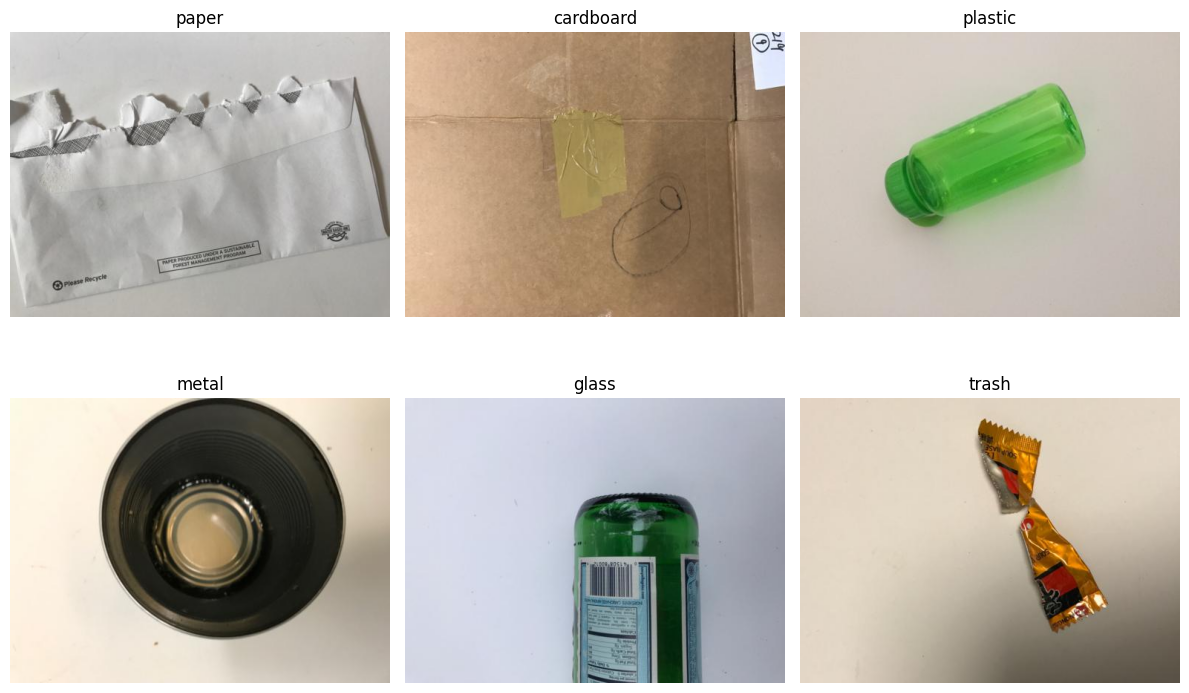

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, cls in zip(axes.flatten(), trash_cls):
    cls_path = os.path.join(dataset_path, cls)
    ax.imshow(Image.open(os.path.join(cls_path, os.listdir(cls_path)[0])))
    ax.set_title(cls)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Análisis de integridad de imagenes

In [5]:
for cls in trash_cls:
    cls_path = os.path.join(dataset_path, cls)
    for img_name in os.listdir(cls_path):
        try:
            img = Image.open(os.path.join(cls_path, img_name))
            img.verify()
        except (UnidentifiedImageError, IOError):
            print(f"Error opening image {img_name} in class {cls}")
            continue
else:
    print(f"All images are valid.")

All images are valid.


- Todas las imágenes del dataset son utilizables. No hay problemas de corrupción o imágenes inválidas.

A continuación se utiliza un índice de similaridad de imágenes para detectar posibles duplicados:

In [6]:
# CODIGO COMENTADO UNICAMENTE POR EL TIEMPO DE EJECUCION
# def compare_images(img1, img2):
#     img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#     img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
#     return ssim(img1, img2)


# for cls in trash_cls:
#     cls_path = os.path.join(dataset_path, cls)
#     images = os.listdir(cls_path)
#     loaded_images = [cv2.imread(os.path.join(cls_path, img)) for img in images]

#     for i in range(len(images)):
#         for j in range(i + 1, len(images)):
#             similarity = compare_images(loaded_images[i], loaded_images[j])
#             if similarity > 0.95:
#                 print(
#                     f"Possible duplicate: {images[i]} / {images[j]} in {cls} (SSIM: {similarity:.2f})"
#                 )

- No existen imagenes duplicadas en el dataset.

### Análisis de distribución de etiquetas

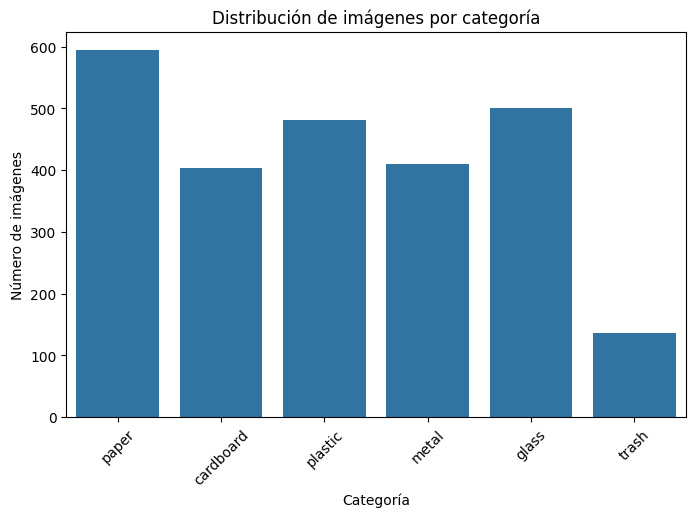

Total number of images: 2527
Number of images in paper: 594
Number of images in cardboard: 403
Number of images in plastic: 482
Number of images in metal: 410
Number of images in glass: 501
Number of images in trash: 137


In [7]:
image_counts = [len(os.listdir(os.path.join(dataset_path, cls))) for cls in trash_cls]
plt.figure(figsize=(8, 5))
sns.barplot(x=trash_cls, y=image_counts)
plt.xlabel("Categoría")
plt.ylabel("Número de imágenes")
plt.title("Distribución de imágenes por categoría")
plt.xticks(rotation=45)
plt.show()

print("Total number of images:", sum(image_counts))
for cls, count in zip(trash_cls, image_counts):
    print(f"Number of images in {cls}: {count}")

Se puede observar que el dataset tiene desbalance de clases. El desbalance se aprecia principalmente por la poca cantidad de imágenes con clase "trash" y una gran cantidad de imágenes con clase "paper" (al menos 90 imágenes más que el resto de categorías).

### Dimensiones de imagenes y relación de aspecto

In [8]:
image_sizes = []
for cls in trash_cls:
    cls_path = os.path.join(dataset_path, cls)
    for img_name in os.listdir(cls_path):
        try:
            img = Image.open(os.path.join(cls_path, img_name))
            img.verify()
        except (UnidentifiedImageError, IOError):
            print(f"Error opening image {img_name} in class {cls}")
            continue
        image_sizes.append(img.size)

print("Image sizes:", set(image_sizes))

Image sizes: {(512, 384)}


- Todas las imágenes del dataset tienen exactamente el mismo tamaño 512x384. Esto simplifica su uso.
- La relación de aspecto será 512/384 = 1.33

## Aplicación de data augmentation
Consiste en generar “nuevos” ejemplos de datos de entrenamiento, para darle más variabilidad a nuestro conjunto de datos. Los nuevos datos pueden generarse a partir de los ya existentes, mediante distintos tipos de transformaciones, o pueden sintetizarse para crear ejemplos completamente nuevos.

Objetivos:
1. Incrementar el tamaño de conjunto de datos
2. Evitar el sobreentrenamiento
3. Permite balancear las clases del conjunto de datos
4. Mejorar las métricas del modelo

El data augmentation se planteará para ser aplicado **online**, es decir, no se generan las nuevas imágenes para guardar como un nuevo dataset.

Definimos una clase que hereda de la clase base dataset para metermitir aplicaciones orientadas para cada clase.

In [26]:
class ClassAugmentDataset(Dataset):
    # def __init__(self, samples, class_transforms, default_transform):
    def __init__(self, samples, default_transform):
        self.samples = samples
        # self.class_transforms = class_transforms
        self.default_transform = default_transform

    def __getitem__(self, index):
        image, label = self.samples[index]
        # transform = self.class_transforms.get(label, self.default_transform)
        transform = self.default_transform
        return transform(image), label

    def __len__(self):
        return len(self.samples)

Para el data augmentation se aplican transformaciones de rotación y espejo, que para los datos en estudio no afectan las características de los objetos a clasificar.

In [20]:
augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    # transforms.ToTensor(),
    # transforms.Normalize([0.5]*3, [0.5]*3)
])

augment_tensor = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

Previsualización de la aumentación aplicada:

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

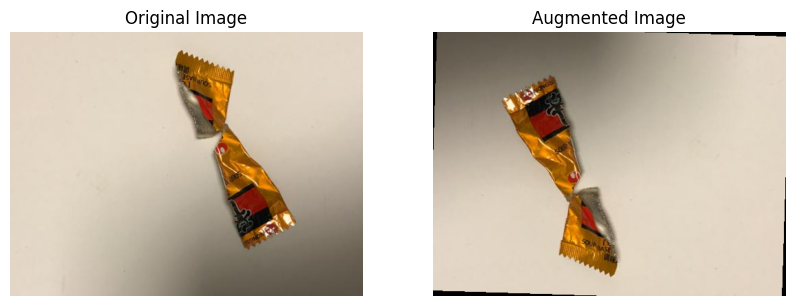

In [21]:
trash_path = os.path.join(dataset_path, "trash")
image_name = os.listdir(trash_path)[0]

img = Image.open(os.path.join(trash_path, image_name))
augmented_img = augment(img)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[0].axis("off")
axs[1].imshow(augmented_img)
axs[1].set_title("Augmented Image")
axs[1].axis("off")

Creación del dataset:

In [32]:
full_dataset = datasets.ImageFolder(root=dataset_path)
dataset = ClassAugmentDataset(full_dataset, default_transform=augment_tensor)

class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


El data augmentation se aplica a través del `WeightedRandomSampler`, que muestrea los datos dada la probabilidad para cada clase.

In [33]:
labels = [label for _, label in dataset]
class_counts = Counter(labels)
class_weights = {cls: len(labels) / count for cls, count in class_counts.items()}
sample_weights = [class_weights[lbl] for lbl in labels]
data_sampler = WeightedRandomSampler(
    sample_weights, num_samples=len(sample_weights), replacement=True
)
data_loader = DataLoader(
    dataset,
    batch_size=64,
    sampler=data_sampler,
    num_workers=4,
)

Chequeo de corrección del desbalance:

Class 'cardboard': 403 samples
Class 'glass': 401 samples
Class 'paper': 401 samples
Class 'trash': 425 samples
Class 'plastic': 483 samples
Class 'metal': 414 samples


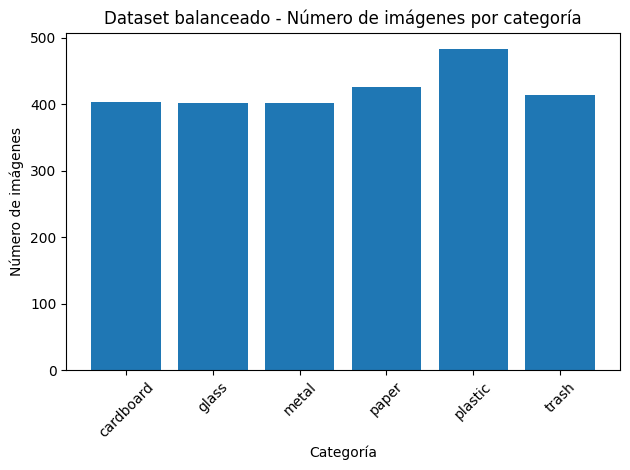

In [36]:
label_counter = Counter()
for _, labels in data_loader:
    label_counter.update(labels.tolist())

for cls_idx, count in label_counter.items():
    print(f"Class '{class_names[cls_idx]}': {count} samples")

plt.bar(class_names, label_counter.values())
plt.title('Dataset balanceado - Número de imágenes por categoría')
plt.xlabel('Categoría')
plt.ylabel('Número de imágenes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

A pesar de utilizar la aumentación online, se desarrollan las herramientas para guardar el dataset ya que es útil para completar el EDA.

In [37]:
def save_images_from_dataloader(loader, class_names, output_dir="augmented_dataset"):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)
    counters = {cls: 0 for cls in class_names}

    for images, labels in loader:
        for img_tensor, label in zip(images, labels):
            class_name = class_names[label.item()]
            img = transforms.functional.to_pil_image(img_tensor)

            save_dir = os.path.join(output_dir, class_name)
            os.makedirs(save_dir, exist_ok=True)

            save_path = os.path.join(save_dir, f"{counters[class_name]:05d}.jpg")
            img.save(save_path)
            counters[class_name] += 1

In [40]:
save_images_from_dataloader(loader=data_loader, class_names=class_names, output_dir="output/augmented_dataset")

## Análisis extra
Se genera un dataframe con propiedades del dataset:
- Se genera un *bounding box* mediante la aplicación de canny para detección de bordes.
- Se analiza el histograma de los canales RGB

In [46]:
def load_image_metadata(dataset_path, class_names):
    image_data = []

    for cls in class_names:
        cls_path = os.path.join(dataset_path, cls)
        if not os.path.exists(cls_path):
            continue

        image_files = os.listdir(cls_path)

        for img_file in image_files:
            img_path = os.path.join(cls_path, img_file)
            try:
                with Image.open(img_path) as img_pil:
                    width, height = img_pil.size
                    format_img = img_pil.format
                    mode = img_pil.mode

                img_cv = cv2.imread(img_path)
                if img_cv is None:
                    continue

                img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

                aspect_ratio = width / height if height > 0 else 0

                img_small = cv2.resize(
                    img_rgb, (50, 50)
                )  # Redimensionar para acelerar, puede ser otro valor
                pixels = img_small.reshape(-1, 3)

                brightness = np.mean(img_small)

                contrast = np.std(img_small)

                edges = canny(cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY), sigma=1.5)
                if np.any(edges):
                    y_indices, x_indices = np.where(edges)
                    if len(x_indices) > 0 and len(y_indices) > 0:
                        x_min, x_max = np.min(x_indices), np.max(x_indices)
                        y_min, y_max = np.min(y_indices), np.max(y_indices)
                        bb_width = x_max - x_min
                        bb_height = y_max - y_min
                        bb_area = bb_width * bb_height
                        bb_coverage = (
                            bb_area / (width * height) if width * height > 0 else 0
                        )
                    else:
                        bb_width, bb_height, bb_area, bb_coverage = 0, 0, 0, 0
                else:
                    bb_width, bb_height, bb_area, bb_coverage = 0, 0, 0, 0

                hist_r = np.histogram(img_rgb[:, :, 0], bins=8, range=(0, 256))[0]
                hist_g = np.histogram(img_rgb[:, :, 1], bins=8, range=(0, 256))[0]
                hist_b = np.histogram(img_rgb[:, :, 2], bins=8, range=(0, 256))[0]

                image_data.append(
                    {
                        "filename": img_file,
                        "class": cls,
                        "width": width,
                        "height": height,
                        "aspect_ratio": aspect_ratio,
                        "format": format_img,
                        "mode": mode,
                        "brightness": brightness,
                        "contrast": contrast,
                        "bb_width": bb_width,
                        "bb_height": bb_height,
                        "bb_area": bb_area,
                        "bb_coverage": bb_coverage,
                        "hist_r": hist_r,
                        "hist_g": hist_g,
                        "hist_b": hist_b,
                    }
                )
            except Exception as e:
                print(f"Error procesando {img_path}: {e}")

    return pd.DataFrame(image_data)


df_images = load_image_metadata("output/augmented_dataset", class_names)

### Análisis de bounding boxes

          bb_width    bb_height        bb_area  bb_coverage
count  2527.000000  2527.000000    2527.000000  2527.000000
mean    508.763356   380.787099  193743.220815     0.985429
std       4.865917     4.741683    3448.089587     0.017538
min     345.000000   252.000000  104148.000000     0.529724
25%     509.000000   381.000000  193929.000000     0.986374
50%     509.000000   381.000000  193929.000000     0.986374
75%     509.000000   381.000000  193929.000000     0.986374
max     509.000000   381.000000  193929.000000     0.986374


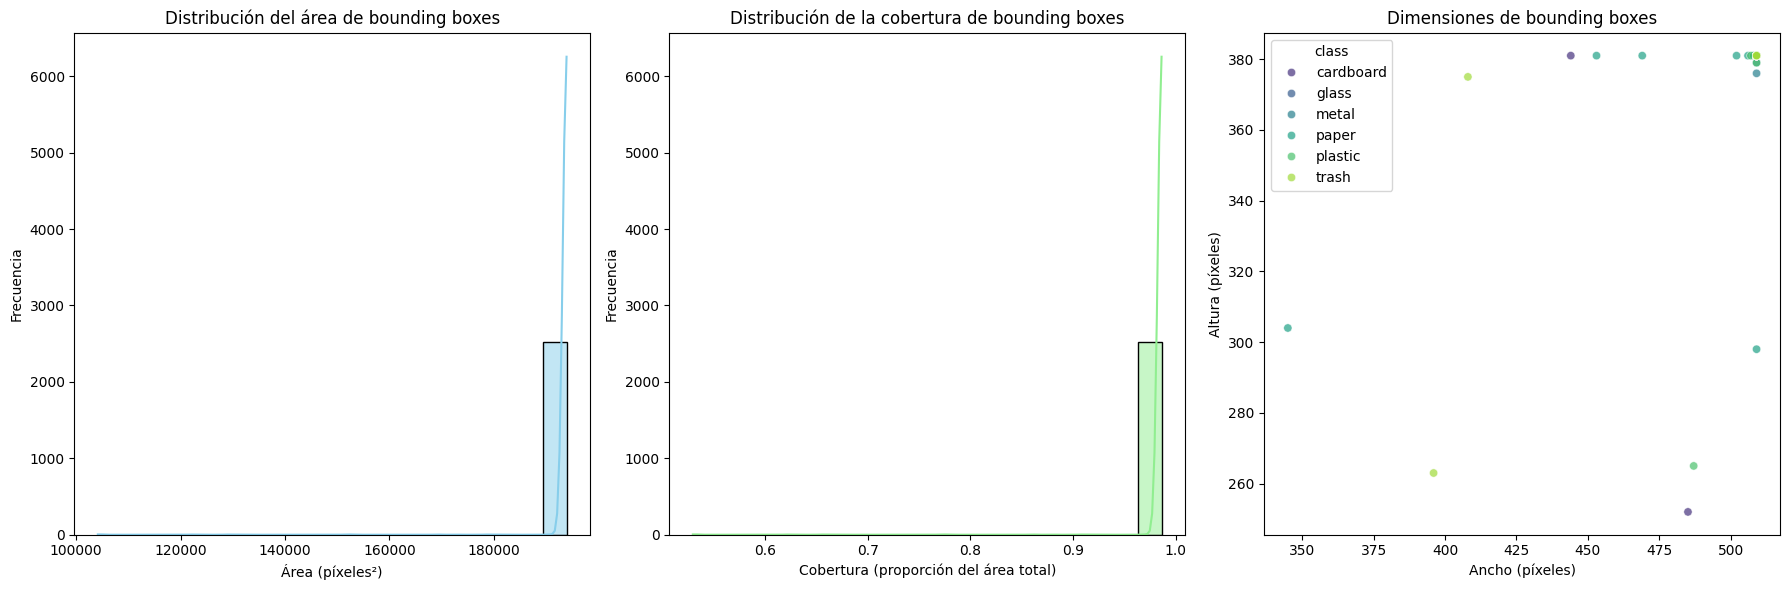

/tmp/ipykernel_478239/2032277358.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="class", y="bb_coverage", data=df_images, palette="viridis")


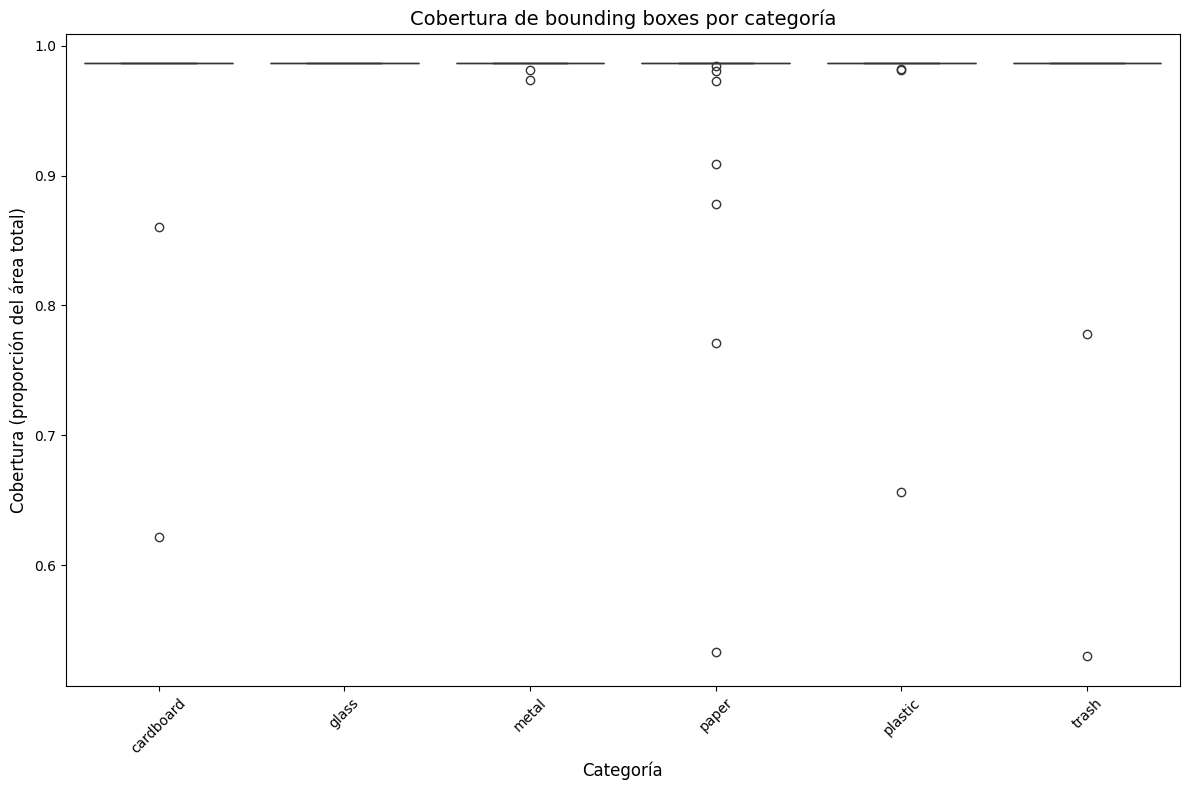

In [44]:
print(df_images[["bb_width", "bb_height", "bb_area", "bb_coverage"]].describe())

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(df_images["bb_area"], bins=20, kde=True, color="skyblue")
plt.title("Distribución del área de bounding boxes", fontsize=12)
plt.xlabel("Área (píxeles²)", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.subplot(1, 3, 2)
sns.histplot(df_images["bb_coverage"], bins=20, kde=True, color="lightgreen")
plt.title("Distribución de la cobertura de bounding boxes", fontsize=12)
plt.xlabel("Cobertura (proporción del área total)", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.subplot(1, 3, 3)
sns.scatterplot(
    x="bb_width",
    y="bb_height",
    hue="class",
    data=df_images,
    palette="viridis",
    alpha=0.7,
)
plt.title("Dimensiones de bounding boxes", fontsize=12)
plt.xlabel("Ancho (píxeles)", fontsize=10)
plt.ylabel("Altura (píxeles)", fontsize=10)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x="class", y="bb_coverage", data=df_images, palette="viridis")
plt.title("Cobertura de bounding boxes por categoría", fontsize=14)
plt.xlabel("Categoría", fontsize=12)
plt.ylabel("Cobertura (proporción del área total)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Análisis de distribución de colores

        brightness     contrast
count  2527.000000  2527.000000
mean    118.864499    65.231025
std      20.397296    10.368089
min      40.364800    23.285202
25%     107.329467    59.305580
50%     119.137867    65.967819
75%     131.032200    72.011789
max     201.358533   107.598288


/tmp/ipykernel_478239/3898563803.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="class", y="brightness", data=df_images, palette="viridis")
/tmp/ipykernel_478239/3898563803.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="class", y="contrast", data=df_images, palette="viridis")


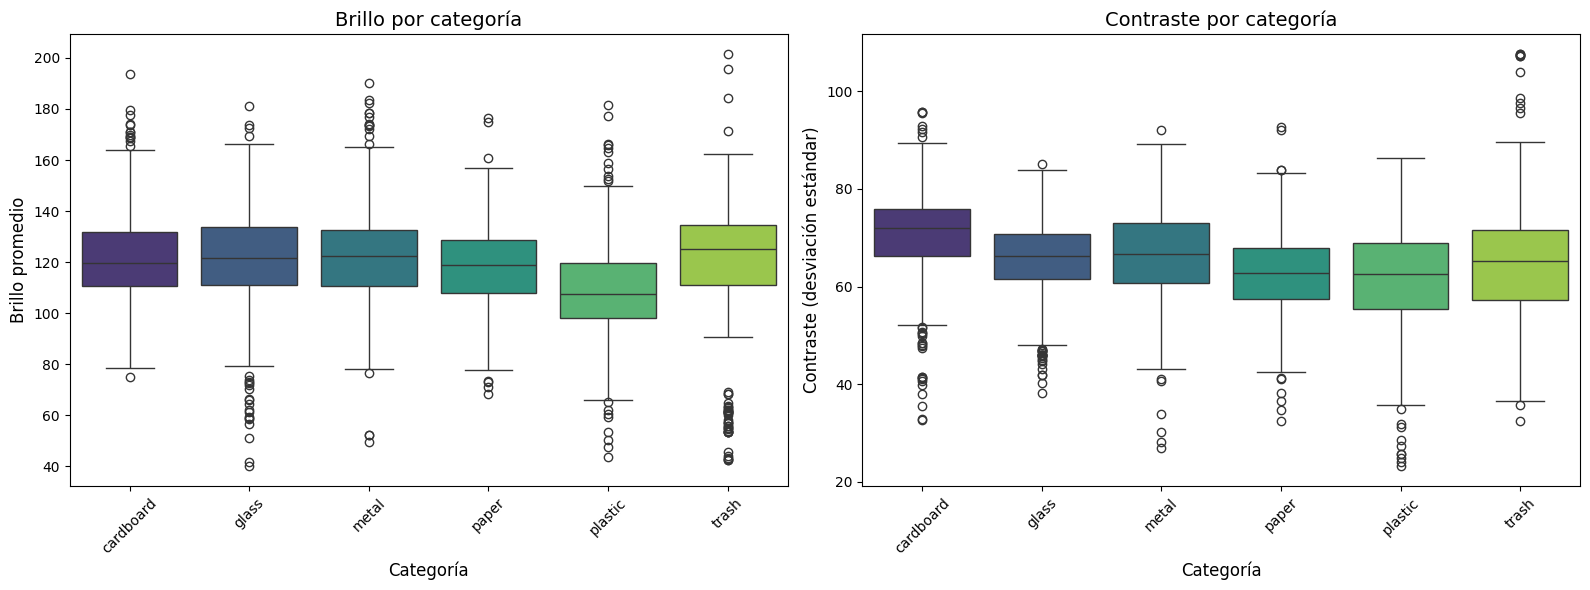

In [51]:
print(df_images[["brightness", "contrast"]].describe())

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x="class", y="brightness", data=df_images, palette="viridis")
plt.title("Brillo por categoría", fontsize=14)
plt.xlabel("Categoría", fontsize=12)
plt.ylabel("Brillo promedio", fontsize=12)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x="class", y="contrast", data=df_images, palette="viridis")
plt.title("Contraste por categoría", fontsize=14)
plt.xlabel("Categoría", fontsize=12)
plt.ylabel("Contraste (desviación estándar)", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

No existe una diferencia clara entre las clases ni en brillo ni en contraste.

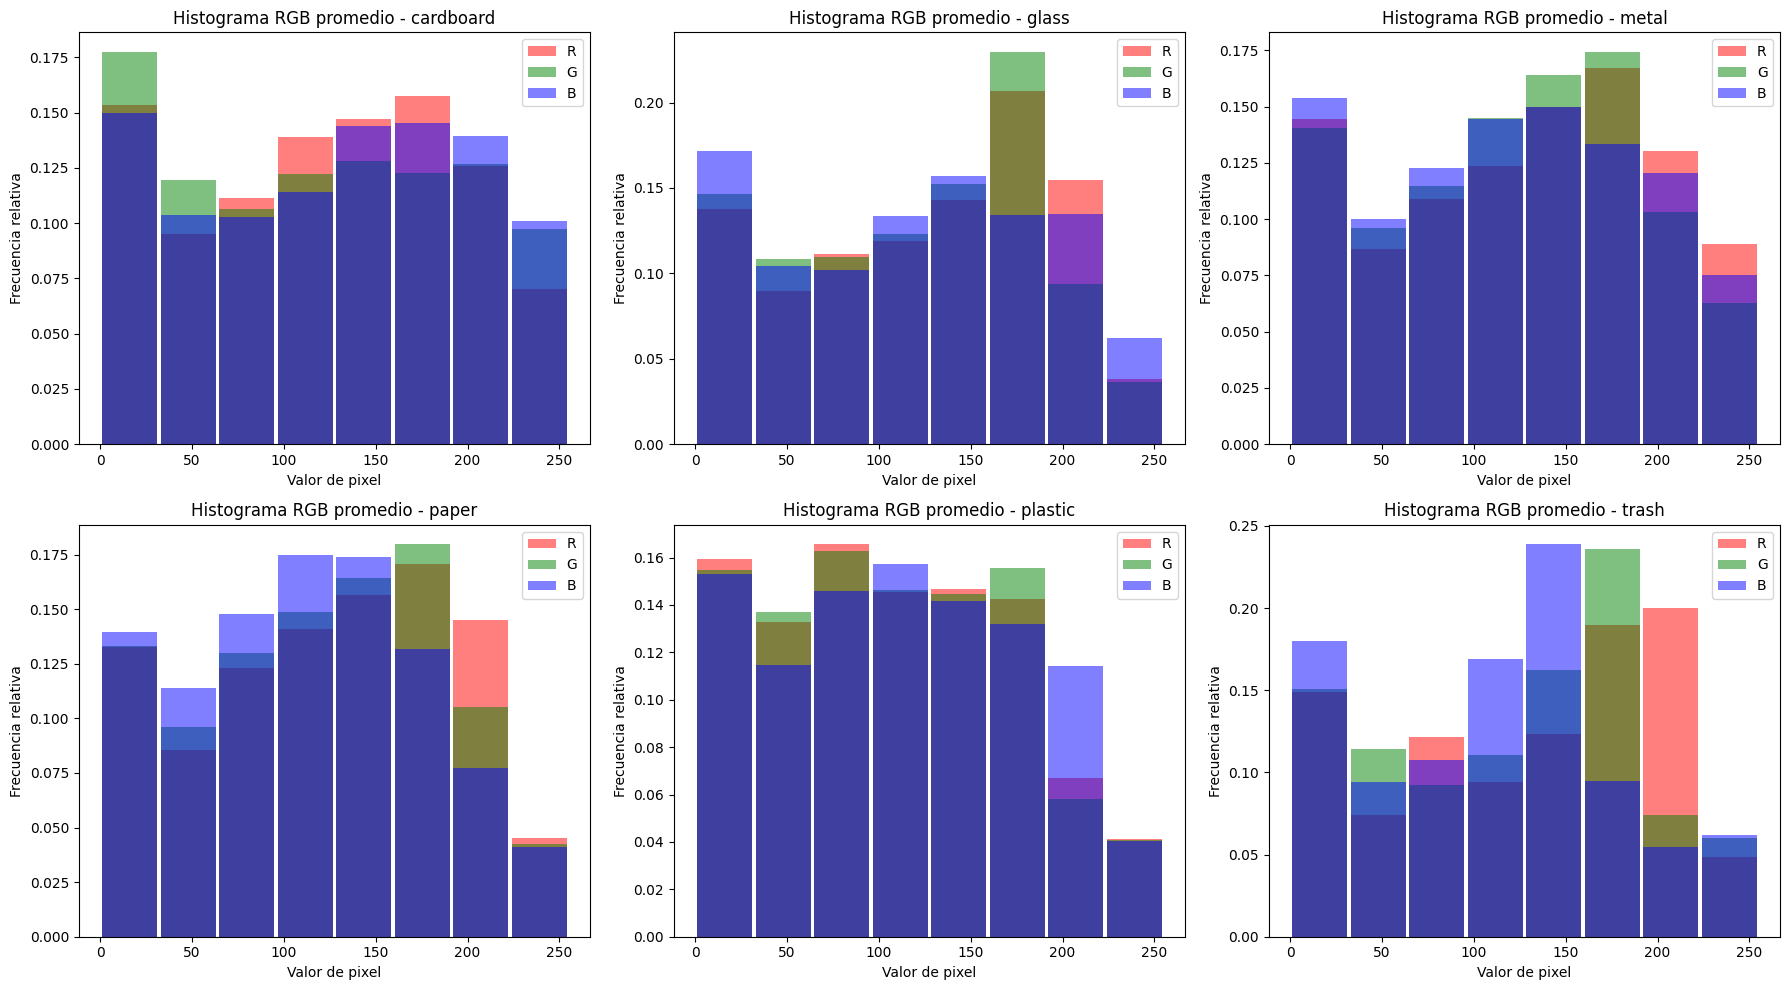

In [59]:
def plot_avg_rgb_hist(df):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, cls in enumerate(class_names):
        category_df = df[df["class"] == cls]
        if len(category_df) == 0:
            continue

        avg_hist_r = np.mean(np.stack(category_df["hist_r"].values), axis=0)
        avg_hist_g = np.mean(np.stack(category_df["hist_g"].values), axis=0)
        avg_hist_b = np.mean(np.stack(category_df["hist_b"].values), axis=0)

        avg_hist_r = (
            avg_hist_r / np.sum(avg_hist_r) if np.sum(avg_hist_r) > 0 else avg_hist_r
        )
        avg_hist_g = (
            avg_hist_g / np.sum(avg_hist_g) if np.sum(avg_hist_g) > 0 else avg_hist_g
        )
        avg_hist_b = (
            avg_hist_b / np.sum(avg_hist_b) if np.sum(avg_hist_b) > 0 else avg_hist_b
        )

        bins = np.linspace(0, 255, 9)  # 8 bins
        bin_centers = (bins[:-1] + bins[1:]) / 2

        axes[i].bar(
            bin_centers, avg_hist_r, color="red", alpha=0.5, width=30, label="R"
        )
        axes[i].bar(
            bin_centers, avg_hist_g, color="green", alpha=0.5, width=30, label="G"
        )
        axes[i].bar(
            bin_centers, avg_hist_b, color="blue", alpha=0.5, width=30, label="B"
        )

        axes[i].set_title(f"Histograma RGB promedio - {cls}", fontsize=12)
        axes[i].set_xlabel("Valor de pixel", fontsize=10)
        axes[i].set_ylabel("Frecuencia relativa", fontsize=10)
        axes[i].legend()

    plt.tight_layout()
    plt.show()

plot_avg_rgb_hist(df_images)

### Análisis de calidad de imágenes
Esta puntuación de calidad recompensa las imágenes con alto contraste y brillo equilibrado, y penaliza las imágenes con bajo contraste, sobreexpuestas o subexpuestas.

count    2527.000000
mean        0.086898
std         0.121758
min         0.004140
25%         0.024823
50%         0.040453
75%         0.082064
max         0.718429
Name: quality_score, dtype: float64


/tmp/ipykernel_478239/4174243978.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="class", y="quality_score", data=df_images, palette="viridis")


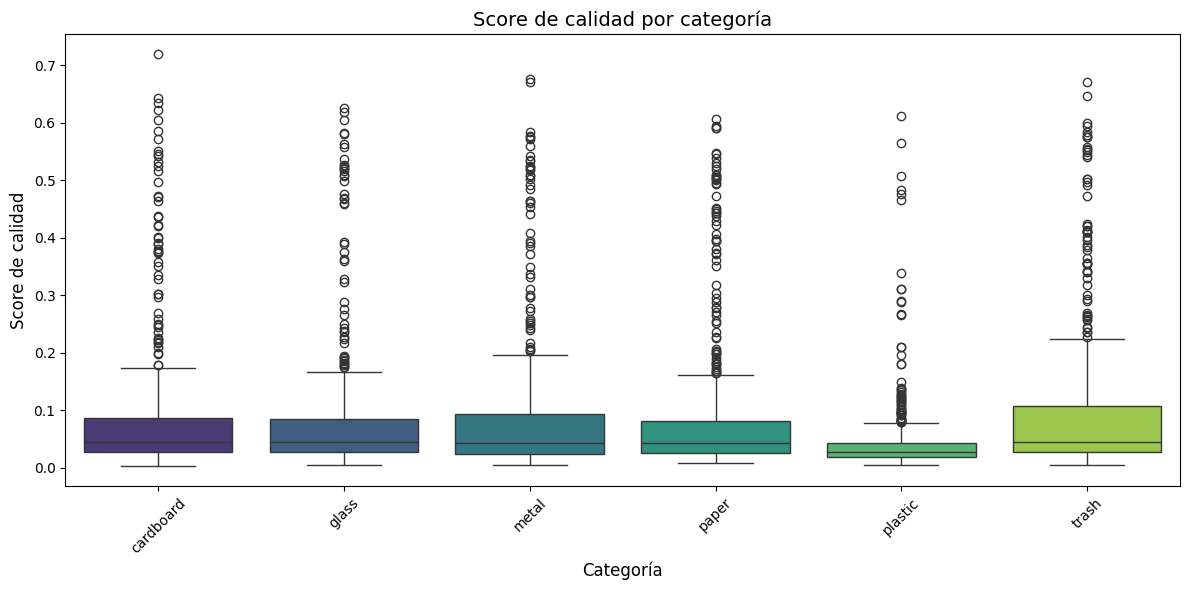

In [48]:
df_images["quality_score"] = df_images["contrast"] / (
    df_images["brightness"].clip(1) * abs(df_images["brightness"] - 128).clip(1)
)

print(df_images["quality_score"].describe())

plt.figure(figsize=(12, 6))
sns.boxplot(x="class", y="quality_score", data=df_images, palette="viridis")
plt.title("Score de calidad por categoría", fontsize=14)
plt.xlabel("Categoría", fontsize=12)
plt.ylabel("Score de calidad", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

No existen diferencias claras entre las clases para la métrica de calidad elegida.

## Tratamiento de residuos

Según la clasificación del residuo, se sugieren los siguientes tratamientos por tipo de residuo:
1. Metal
    - Reciclable
    - Tratamiento: Se recolecta, separa (aluminio, acero, etc.) y se funde para reutilizar en la fabricación de nuevos productos.
2. Vidrio (glass)
    - Reciclable indefinidamente
    - Tratamiento: Se tritura, limpia y funde para formar nuevos envases. No pierde calidad.
3. Papel
    - Reciclable (si no está sucio)
    - Tratamiento: Se tritura, mezcla con agua, se prensa y se seca para formar papel reciclado.
4. Basura (trash)
    - No reciclable (mezcla de residuos orgánicos e inorgánicos no tratados)
    - Tratamiento: Se lleva a rellenos sanitarios o plantas de incineración (con o sin recuperación de energía).
5. Cartón (cardboard)
    - Reciclable
    - Tratamiento: Igual que el papel, pero es más grueso y resistente.
6. Plástico
    - Reciclable con clasificación
    - Tratamiento: Se  tritura y se reutiliza.